In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [304]:
def evaluate_Q_at(model, y_val, solver):
    """
    Given y = y_val , minimize obj_expr and return v(y).
    This function temporarily increments the objective and clears it after completion, without changing the model structure.
    """
    # Clear any remaining As/pw/obj (to prevent it from being left over from the previous round)
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, create a temporary target and solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # check if solution okay
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)
    # clear temporarily objective
    model.del_component('obj')
    model.y.unfix()
    return v_y

def nc_underest(bounds, model_list, add_node_num, tolerance=1e-8):
    """
    Parameters:
        bounds (list): contains 2 float which is lower and upper bound of variable
        model (list): model with submodels corresponds to each scenario
        add_node_num (float): number of sample nodes
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    new_lb = bounds[0]
    new_ub = bounds[1]
    eff_node_count = 0 #  count how many extra nodes were actually added
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N
    active = [True] * N  # check if this scenario has been optimized
    under_tol = 1e-8

    # set up solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-8
    solver.options['OptimalityTol'] = 1e-8
    solver.options['NonConvex'] = 2 
    
    # start with 2 nodes
    y_nodes = bounds
    for i in range(N):
        as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
 
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(3,add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            
            if not active[i]:
                continue  #this scenario has been optimized
                
            print('Solving scenario ',i)
            # define piecewise function for each scenario
            for comp in ['obj', 'As', 'pw']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set ip objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            
            if (results.solver.status != SolverStatus.ok) or \
               (results.solver.termination_condition != TerminationCondition.optimal):
                print("⚠ There may be problems with the solution")
                
            #ms_list[i] = results.problem.lower_bound
            ms_list[i] = value(model_list[i].obj)
            if ms_list[i] >= -under_tol:
                active[i] = False

            '''
            # check if new node is too close to old nodes         
            if (k > 0) and (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
                break
            '''
                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)

        if k < add_node_num:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            if (new_node not in y_nodes) and (k != add_node_num):
                idx = bisect.bisect_left(y_nodes, new_node)
                y_nodes.insert(idx, new_node)
                for i in range(N):
                    as_nodes_list[i].insert(idx, evaluate_Q_at(model_list[i], new_node, solver))
                #bisect.insort(y_nodes, new_node)
                eff_node_count += 1
                
        if not any(active):
            print("[stop] all scenario is underestimator")
            print("Add ",k," nodes")
            break

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = mmm-errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count, min_index,new_node

In [305]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return -(y-1)**2+1

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(0, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(0, 1))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == -(m2.y-1)**2)
m2.obj_expr = Expression(expr=m2.x2+1)

model_list = [m1, m2]
# lower bound and upper bound
ylb = 0
yub = 0.2
bounds = [ylb, yub]

# Plot the figures and error

In [306]:
# make delta list
adds = np.arange(6, 10)
results = [nc_underest([ylb, yub],[m1,m2],a) for a in adds]

start
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Adding node  5
Solving scenario  0
Adding node  6
Solving scenario  0
start
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Adding node  5
Solving scenario  0
Adding node  6
Solving scenario  0
Adding node  7
Solving scenario  0
start
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Adding node  5
Solving scenario  0
Adding node  6
Solving scenario  0
Adding node  7
Solving scenario  0
Adding node  8
Solving scenario  0
start
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Adding node  5
Solving scenario  0
Adding node  6
Solving scenario  0
Adding node  7
Solving scenario  0
Adding node  8
Solving scenario  0
Adding node  9
Solving scenario  0


   
   
   
effective add node num  0
y node is  [0.       0.003125 0.0125   0.05     0.2     ]
y node length 5
ms value is  [-0.018633794998004383, 0.0]
new_nodes is  0.003125
this time choose scenario  0


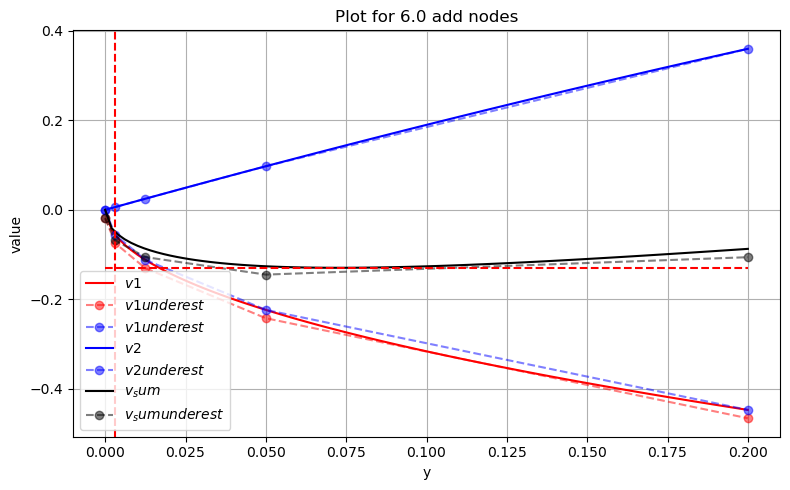

   
   
   
effective add node num  0
y node is  [0.         0.003125   0.0125     0.05       0.11232219 0.2       ]
y node length 6
ms value is  [-0.013975424859373689, 0.0]
new_nodes is  0.11232219320515045
this time choose scenario  0


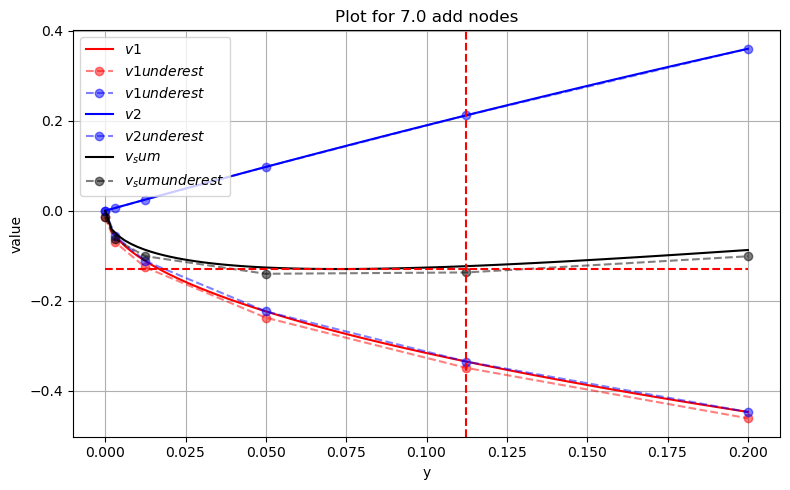

   
   
   
effective add node num  0
y node is  [0.         0.00078125 0.003125   0.0125     0.05       0.11232219
 0.2       ]
y node length 7
ms value is  [-0.00931676855069069, 0.0]
new_nodes is  0.0007812500000000002
this time choose scenario  0


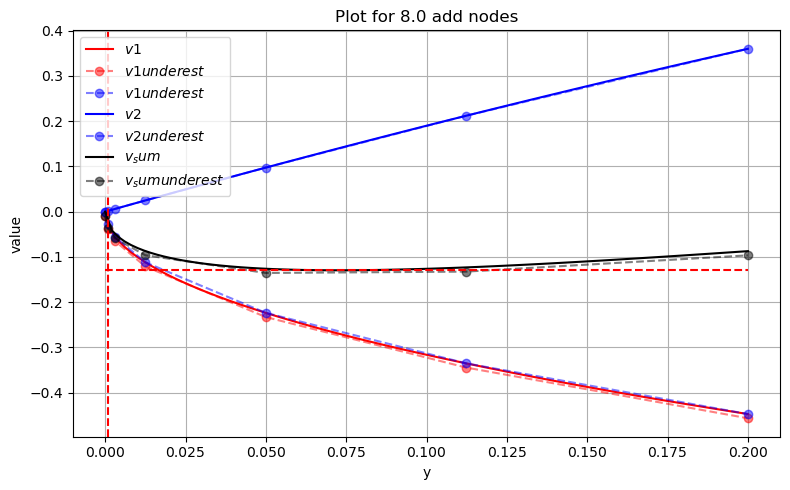

   
   
   
effective add node num  0
y node is  [0.         0.00078125 0.003125   0.0125     0.02820778 0.05
 0.11232219 0.2       ]
y node length 8
ms value is  [-0.0069877124296868435, 0.0]
new_nodes is  0.028207784504935524
this time choose scenario  0


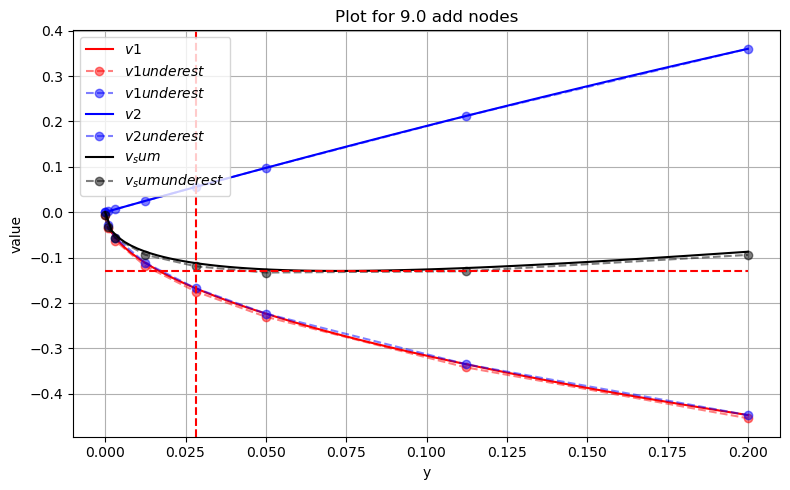

In [291]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    '''
    
    '''
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.015224081114811244, 0.010565710976180559, 0.005907054667497552, 0.0035779985464937103]


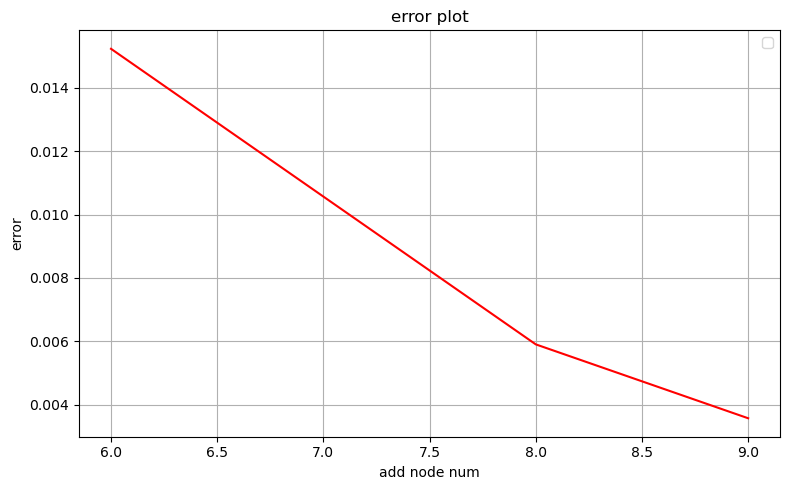

In [303]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
plt.plot(adds, errors, color='red')

plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

   
   
   
effective add node num  0
y node is  [0.     0.0125 0.05   0.1    0.15   0.2   ]
y node length 6
ms value is  [-0.027951848169054865, -1.4387645588809228e-10]
new_nodes is  0.012500000000000004
this time choose scenario  0


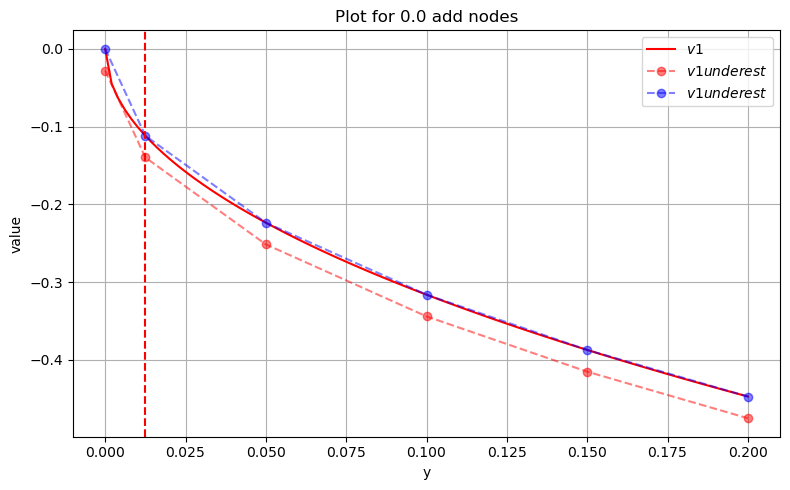

   
   
   
effective add node num  0
y node is  [0.       0.003125 0.0125   0.05     0.1      0.15     0.2     ]
y node length 7
ms value is  [-0.013975572313856943, -1.4387648190894442e-10]
new_nodes is  0.003125
this time choose scenario  0


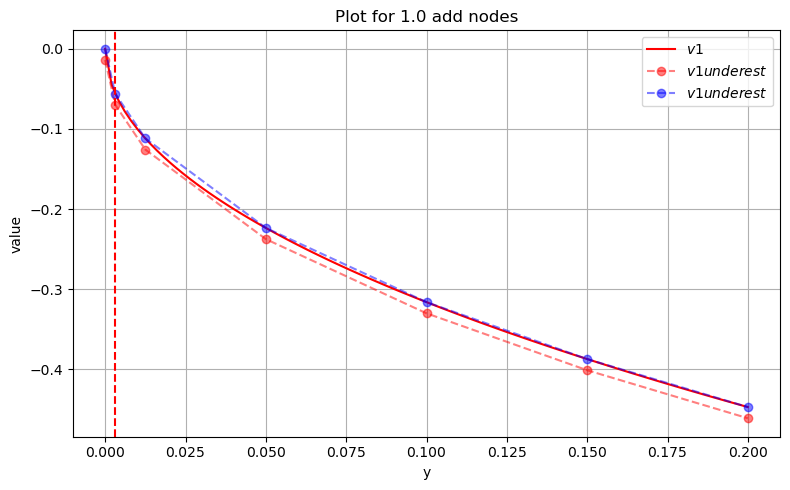

   
   
   
effective add node num  0
y node is  [0.         0.00078125 0.003125   0.0125     0.05       0.1
 0.15       0.2       ]
y node length 8
ms value is  [-0.009316992593035603, -4.671268855013793e-10]
new_nodes is  0.0007812500000000002
this time choose scenario  0


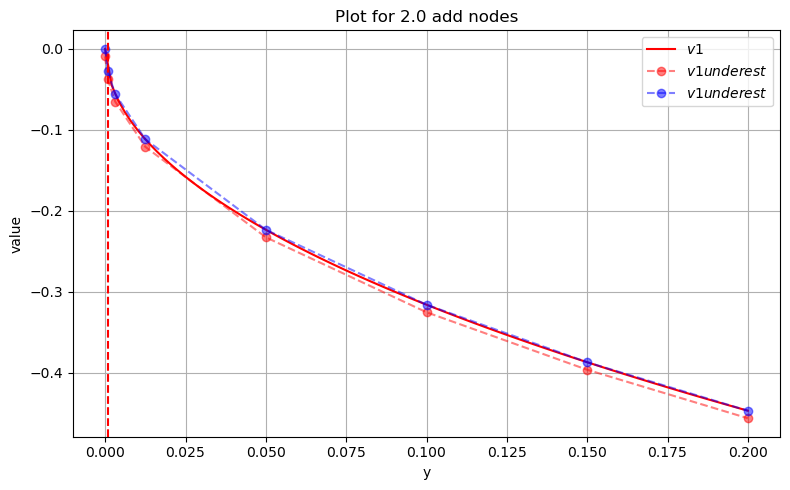

   
   
   
effective add node num  0
y node is  [0.         0.00078125 0.003125   0.0125     0.0281149  0.05
 0.1        0.15       0.2       ]
y node length 9
ms value is  [-0.006987735007687774, -2.1378602824118596e-10]
new_nodes is  0.028114895722420322
this time choose scenario  0


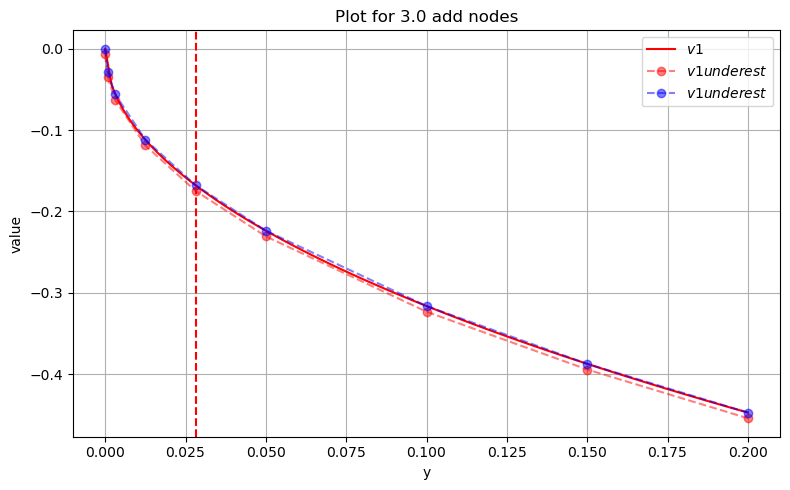

   
   
   
effective add node num  0
y node is  [0.00000000e+00 1.95733398e-04 7.81250000e-04 3.12500000e-03
 1.25000000e-02 2.81148957e-02 5.00000000e-02 1.00000000e-01
 1.50000000e-01 2.00000000e-01]
y node length 10
ms value is  [-0.004658576058229544, -4.203367884827487e-10]
new_nodes is  0.0001957333975695144
this time choose scenario  0


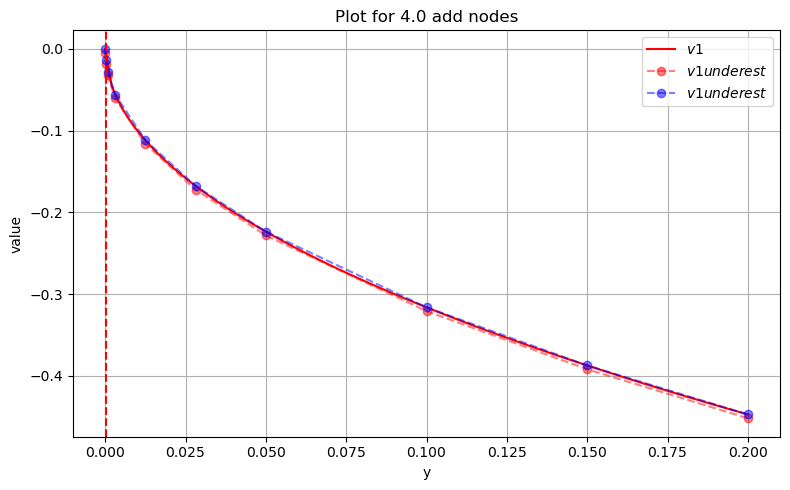

   
   
   
effective add node num  0
y node is  [0.00000000e+00 1.95733398e-04 7.81250000e-04 3.12500000e-03
 7.02968991e-03 1.25000000e-02 2.81148957e-02 5.00000000e-02
 1.00000000e-01 1.50000000e-01 2.00000000e-01]
y node length 11
ms value is  [-0.0039728437311109255, -3.182957674808318e-10]
new_nodes is  0.007029689905145065
this time choose scenario  0


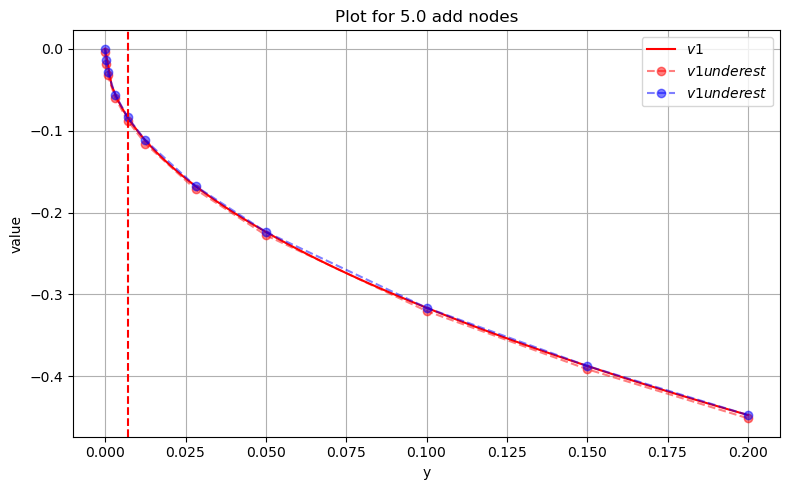

   
   
   
effective add node num  0
y node is  [0.00000000e+00 1.95733398e-04 7.81250000e-04 3.12500000e-03
 7.02968991e-03 1.25000000e-02 2.81148957e-02 5.00000000e-02
 7.28481372e-02 1.00000000e-01 1.50000000e-01 2.00000000e-01]
y node length 12
ms value is  [-0.0034976454957957055, -3.182957674808318e-10]
new_nodes is  0.07284813723660287
this time choose scenario  0


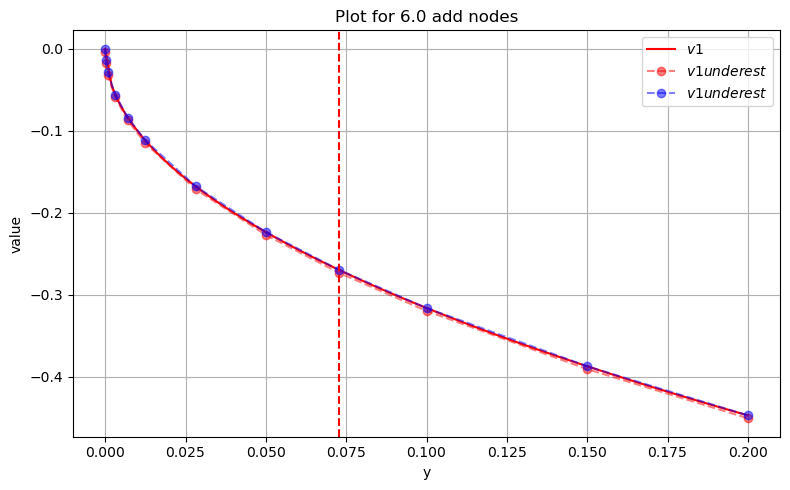

   
   
   
effective add node num  0
y node is  [0.00000000e+00 4.90285499e-05 1.95733398e-04 7.81250000e-04
 3.12500000e-03 7.02968991e-03 1.25000000e-02 2.81148957e-02
 5.00000000e-02 7.28481372e-02 1.00000000e-01 1.50000000e-01
 2.00000000e-01]
y node length 13
ms value is  [-0.002792376116321167, -4.092051547599767e-10]
new_nodes is  4.90285499451248e-05
this time choose scenario  0


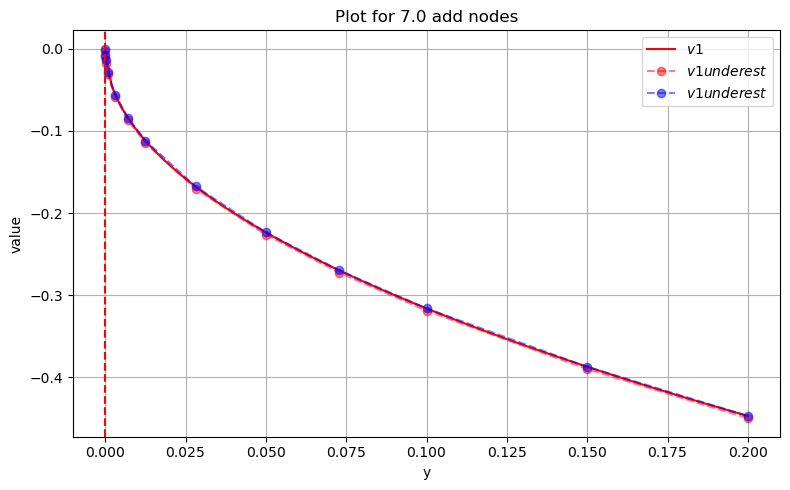

   
   
   
effective add node num  0
y node is  [0.00000000e+00 4.90285499e-05 1.95733398e-04 7.81250000e-04
 3.12500000e-03 7.02968991e-03 1.25000000e-02 1.95236206e-02
 2.81148957e-02 5.00000000e-02 7.28481372e-02 1.00000000e-01
 1.50000000e-01 2.00000000e-01]
y node length 14
ms value is  [-0.002329267260955118, -4.4763997708899905e-10]
new_nodes is  0.019523620605467855
this time choose scenario  0


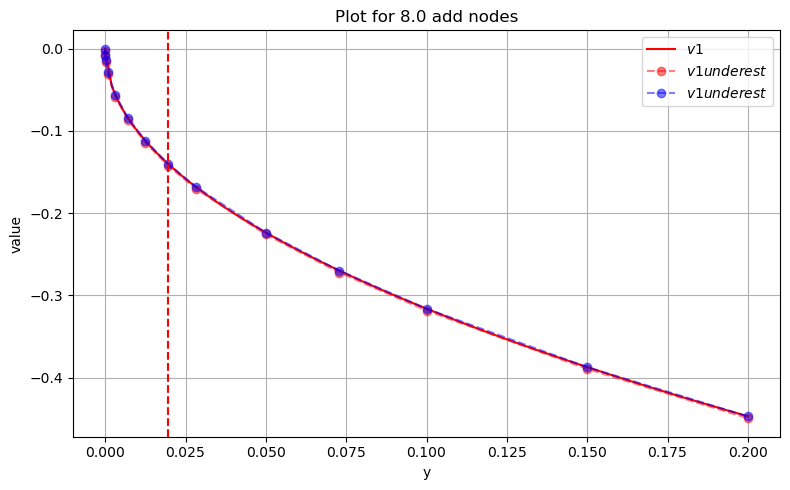

In [189]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    '''
    
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.1)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {i:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [204]:
ms1s

[[0.0, 0.09750000000000003, 0.3599999999999999],
 [0.0, 0.024843749999999942, 0.09750000000000003, 0.3599999999999999],
 [0.0,
  0.006240234375000098,
  0.024843749999999942,
  0.09750000000000003,
  0.3599999999999999],
 [0.0,
  0.006240234375000098,
  0.024843749999999942,
  0.09750000000000003,
  0.21202811132388577,
  0.3599999999999999],
 [0.0,
  0.0015618896484373979,
  0.006240234375000098,
  0.024843749999999942,
  0.09750000000000003,
  0.21202811132388577,
  0.3599999999999999],
 [0.0,
  0.0015618896484373979,
  0.006240234375000098,
  0.024843749999999942,
  0.05561988990319422,
  0.09750000000000003,
  0.21202811132388577,
  0.3599999999999999],
 [0.0,
  0.0003912866178524821,
  0.0015618896484373979,
  0.006240234375000098,
  0.024843749999999942,
  0.05561988990319422,
  0.09750000000000003,
  0.21202811132388577,
  0.3599999999999999],
 [0.0,
  0.0003912866178524821,
  0.0015618896484373979,
  0.006240234375000098,
  0.024843749999999942,
  0.05561988990319422,
  0.09750

[0.05249518897146274, 0.0245411916334016, 0.01522433120687619, 0.010565799368789597, 0.005907806571854302, 0.003578024016370307, 0.0021566141466186073, 0.0045084798421498595, 0.0038633204721053305, 0.00334690172232327, 0.002667216238965514, 0.002179147441599999, 0.0018275571196117724, 0.00160021615538114]


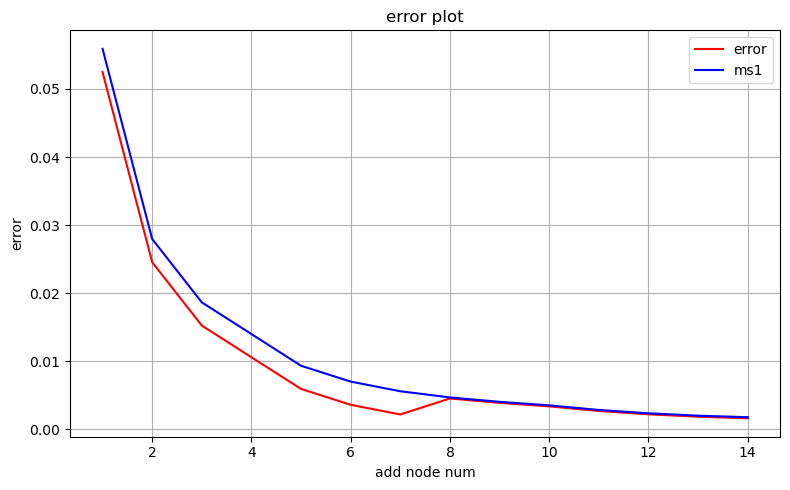

In [207]:
plt.figure(figsize=(8, 5))
errors = [item[1] for item in results]
ms1s = [-item[4] for item in results]


plt.plot(adds, errors, color='red',label='error')
plt.plot(adds, ms1s, color='blue',label='ms1')
plt.xlabel('add node num')
plt.ylabel('error')
plt.title(f"error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()

print(errors)

In [71]:
errors

[0.05261493353885349,
 0.02466310269684402,
 0.010686826841646235,
 0.006028247444075374,
 0.0036989896053867266,
 0.0013698308624792155,
 0.0006840984333196243,
 0.003495651564627167,
 0.0027903822760619867,
 0.002327273459130863,
 0.001996803133321068,
 0.0017929039039972228,
 0.0017485693658303436,
 0.001394714262227481,
 0.001159715011047835]

In [170]:
m = ConcreteModel()
m.y = Var(bounds=(0, 1))
m.x1 = Var(bounds=(0, 1))
m.x11 = Var(bounds=(0, None))
m.x2 = Var()
m.c1 = Constraint(expr=m.x11**2 == m.y**2)
m.c2 = Constraint(expr=m.x11 == (m.x1)**2)
m.c3 = Constraint(expr=m.x2 == -(m.y-1)**2)
m.obj = Objective(expr=-m.x1+m.x2+1, sense=minimize)

In [171]:
solver = SolverFactory('gurobi')
solver.options['FeasibilityTol'] = 1e-9
solver.options['OptimalityTol'] = 1e-9
solver.options['NonConvex'] = 2 

In [172]:
results = solver.solve(m)
mmm = results.problem.lower_bound

In [173]:
mmm

-0.12951651163317207

# 以下研究6和7发生了什么

In [150]:
delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count, min_index,new_node

NameError: name 'delta' is not defined

In [151]:
results6 = nc_underest(ylb,yub,v_list,[m1,m2],6)
results7 = nc_underest(ylb,yub,v_list,[m1,m2],7)

start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
start
Adding node  0
Solving scenario  0
Solving scenario  1
Adding node  1
Solving scenario  0
Solving scenario  1
Adding node  2
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted
Adding node  3
Solving scenario  0
Solving scenario  1
Adding node  4
Solving scenario  0
Solving scenario  1
Adding node  5
Solving scenario  0
Solving scenario  1
Adding node  6
Solving scenario  0
Solving scenario  1
Adding node  7
Solving scenario  0
Solving scenario  1
The new node is too close and not inserted


In [175]:
errors6 = results6[1]
errors7 = results7[1]
y_nodes6 = results6[2]
y_nodes7 = results7[2]
as_nodes_list61 = results6[3]
as_nodes_list71 = results7[3]
ms_list61 = results6[4]
ms_list71 = results7[4]
as_nodes_list62 = results6[5]
as_nodes_list72 = results7[5]
ms_list62 = results6[6]
ms_list72 = results7[6]

assum_nodes6 = np.sum([as_nodes_list61,as_nodes_list62], axis=0)
ms6 = ms_list61+ms_list62
assum_nodes7 = np.sum([as_nodes_list71,as_nodes_list72], axis=0)
ms7 = ms_list71+ms_list72

y_vals = np.linspace(ylb, yub, 100)
Qs_vals1 = [v_list[0](y) for y in y_vals]
Qs_vals2 = [v_list[1](y) for y in y_vals]
Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

In [167]:
print(errors6)
print(errors7)
print(ms6)
print(ms7)

0.0006840984330726274
0.0034956515643803365
-0.003972844049406693
-0.003497645814091473


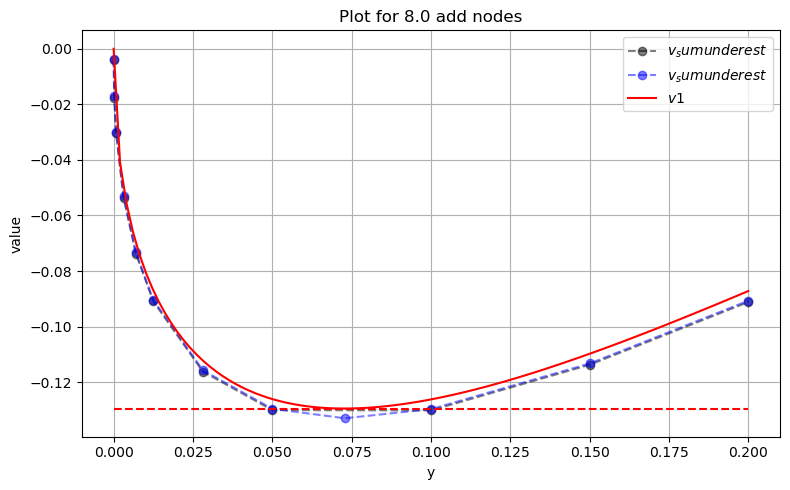

In [176]:
plt.figure(figsize=(8, 5))
'''
plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)

plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
'''

plt.plot(y_nodes6, assum_nodes6+ms6,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
plt.plot(y_nodes7, assum_nodes7+ms7,label=r'$v_sum underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
plt.plot(y_vals, Qs_vals_sum, label=r'$v1$', color='red')

plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')


plt.xlabel('y')
plt.ylabel('value')
plt.title(f"Plot for {i:.1f} add nodes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = mmm-errors